TODO:
1) EDA
2) Run some training script (ready opensource solution)
3) Analyse results (confusion matrix, some exact cases)

In [ ]:
!pip install -U transformers==4.46.3 evaluate==0.4.6 seqeval==1.2.2 datasets==3.1.0 transformers==4.46.3 torch torcheval torchmetrics torchvision

In [ ]:
import numpy as np
from datasets import load_dataset, Dataset, DatasetDict
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
    BatchEncoding,
    set_seed,
)
import torch
import random
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def set_all_seeds(seed: int):
    random.seed(seed)  # Python random seed
    np.random.seed(seed)  # NumPy random seed
    torch.manual_seed(seed)  # PyTorch CPU seed
    torch.cuda.manual_seed(seed)  # PyTorch CUDA seed
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = (
        True  # Ensure deterministic computation in cuDNN
    )
    torch.backends.cudnn.benchmark = (
        False  # Disable cuDNN auto-tuner for reproducibility
    )
    set_seed(seed)  # Hugging Face transformers seed setting


set_all_seeds(1337)

In [3]:
ds = load_dataset("ramybaly/conll2012")

In [4]:
LABEL_NAMES = [
    "O",
    "B-CARDINAL",  # –∫–æ–ª–∏—á–∏—Å—Ç–≤–µ–Ω–Ω—ã–µ —á–∏—Å–ª–∏—Ç–µ–ª—å–Ω—ã–µ: three, 200, one million, ...
    "B-DATE",  # –¥–∞—Ç—ã
    "B-EVENT",  # —Å–æ–±—ã—Ç–∏—è: Olympic games, Easter, ...
    "B-FAC",  # —Å–æ–æ—Ä—É–∂–µ–Ω–∏—è (facilities): Eiffel Tower, JFK airport, ...
    "B-GPE",  # –≥–µ–æ–ø–æ–ª–∏—Ç–∏—á–µ—Å–∫–∏–µ –æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è: New York, Texas, ...
    "B-LANGUAGE",  # —è–∑—ã–∫–∏: English, French, ...
    "B-LAW",  # –∑–∞–∫–æ–Ω—ã –∏ –Ω–æ—Ä–º–∞—Ç–∏–≤–Ω—ã–µ –∞–∫—Ç—ã: Constitution, Civil Rights Act, ...
    "B-LOC",  # –≥–µ–æ–≥—Ä–∞—Ñ–∏—á–µ—Å–∫–∏–µ –ª–æ–∫–∞—Ü–∏–∏: Mount Everest, Nile River, ...
    "B-MONEY",  # –¥–µ–Ω–µ–∂–Ω—ã–µ –≤—ã—Ä–∞–∂–µ–Ω–∏—è: $5, 10 euros, five million rubles
    "B-NORP",  # –Ω–∞—Ü–∏–æ–Ω–∞–ª—å–Ω–æ—Å—Ç–∏, —Ä–µ–ª–∏–≥–∏–∏, –ø–æ–ª–∏—Ç–∏—á–µ—Å–∫–∏–µ –≥—Ä—É–ø–ø—ã: Russians, Buddhists, Republicans, ...
    "B-ORDINAL",  # –ø–æ—Ä—è–¥–∫–æ–≤—ã–µ —á–∏—Å–ª–∏—Ç–µ–ª—å–Ω—ã–µ: first, second, third, ...
    "B-ORG",  # –æ—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏–∏: Google, United Nations, ...
    "B-PERCENT",  # –ø—Ä–æ—Ü–µ–Ω—Ç—ã: 50%, twenty percent
    "B-PERSON",  # –∏–º–µ–Ω–∞ –ª—é–¥–µ–π: David Lynch, Maxim Kats, ...
    "B-PRODUCT",  # –ø—Ä–æ–¥—É–∫—Ç—ã –∏ –±—Ä–µ–Ω–¥—ã: Coca-Cola, Iphone, ...
    "B-QUANTITY",  # –∏–∑–º–µ—Ä—è–µ–º—ã–µ –≤–µ–ª–∏—á–∏–Ω—ã —Å –µ–¥–∏–Ω–∏—Ü–∞–º–∏: 5kg, 10 meters, ...
    "B-TIME",  # –≤—Ä–µ–º—è: 2 a.m., morning, ...
    "B-WORK_OF_ART",  # –ø—Ä–æ–∏–∑–≤–µ–¥–µ–Ω–∏—è –∏—Å–∫—É—Å—Å—Ç–≤–∞: Mona Lisa, –í–æ—Ä–æ–Ω–∏–Ω—ã, ...
    "I-CARDINAL",
    "I-DATE",
    "I-EVENT",
    "I-FAC",
    "I-GPE",
    "I-LANGUAGE",
    "I-LAW",
    "I-LOC",
    "I-MONEY",
    "I-NORP",
    "I-ORDINAL",
    "I-ORG",
    "I-PERCENT",
    "I-PERSON",
    "I-PRODUCT",
    "I-QUANTITY",
    "I-TIME",
    "I-WORK_OF_ART",
]

ENTITY_MAPPING = {i: ent for i, ent in enumerate(LABEL_NAMES)}

In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'tags'],
        num_rows: 115812
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'tags'],
        num_rows: 15680
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'tags'],
        num_rows: 12217
    })
})

In [6]:
ds_train = ds["train"].remove_columns(["id", "pos_tags"])
ds_val = ds["validation"].remove_columns(["id", "pos_tags"])
ds_test = ds["test"].remove_columns(["id", "pos_tags"])

df_train = ds_train.to_pandas()
df_val = ds_val.to_pandas()
df_test = ds_test.to_pandas()

In [7]:
df_train

tokens  \
0                             [Big, Managers, on, Campus]   
1       [In, recent, years, ,, advanced, education, fo...   
2       [With, this, trend, ,, suddenly, the, mature, ...   
3       [In, order, to, attract, this, group, of, seas...   
4       [In, response, ,, each, year, over, 1000, matu...   
...                                                   ...   
115807  [In, fact, ,, Iraq, has, almost, sunk, into, a...   
115808  [The, same, day, ,, the, US, National, Broadca...   
115809  [Analysts, here, have, pointed, out, that, Ann...   
115810  [Calls, from, within, the, US, for, the, withd...   
115811  [On, the, 29th, and, 30th, of, this, month, ,,...   

                                                     tags  
0                                            [0, 0, 0, 0]  
1       [0, 2, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 27, 27...  
4       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  
...                                                   ...  
115807  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
115808  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
115809  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
115810  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
115811  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[115812 rows x 2 columns]

In [12]:
classes_cnt = {}
for tag_arr in tqdm(df_train['tags']):
    for cls_num in tag_arr:
        cls_name = ENTITY_MAPPING[cls_num]
        if cls_name != "O":
            cls_name = cls_name[2:]
        if cls_name not in classes_cnt:
            classes_cnt[cls_name] = 1
        else:
            classes_cnt[cls_name] += 1

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 115812/115812 [00:00<00:00, 237060.63it/s]


Text(0.5, 1.0, 'Token classes distribution in train dataset')

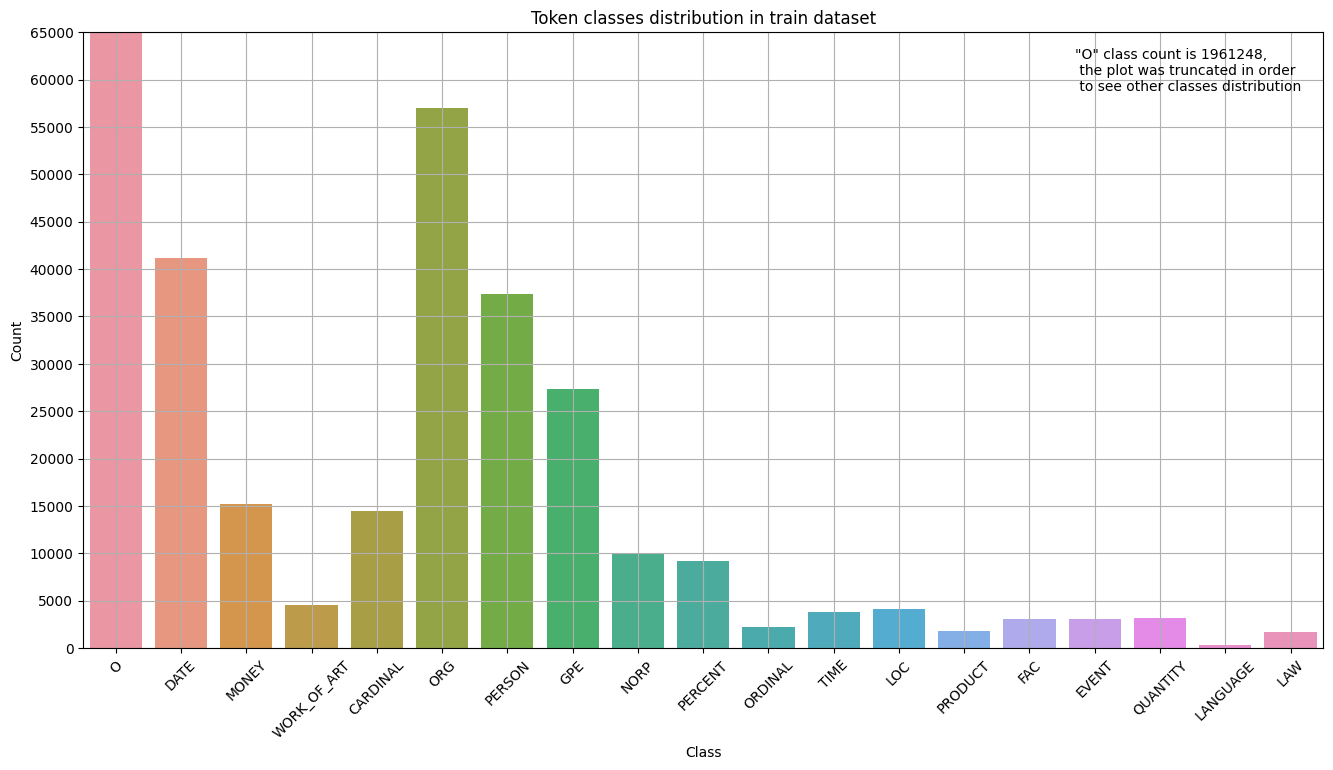

In [47]:
df = pd.DataFrame(list(classes_cnt.items()), columns=['Class', 'Count'])

# Create the bar plot using Seaborn
plt.figure(figsize=(16, 8)) # Optional: Adjust figure size
sns.barplot(x='Class', y='Count', data=df)
plt.yticks(np.arange(0, max(df['Count'])+1, 5000))
plt.ylim((0, 0.065*1e6))
plt.xticks(rotation=45) 
plt.text(0.80, 0.90, f'"O" class count is {classes_cnt["O"]},\n the plot was truncated in order\n to see other classes distribution',
         horizontalalignment='left',
         verticalalignment='bottom',
         transform=plt.gca().transAxes,
         fontsize=10,
         color='black')
plt.grid(True)

# Add a title to the plot
plt.title('Token classes distribution in train dataset')

In [ ]:
idx = 6
dict(
    zip(
        df_train.iloc[idx]["tokens"],
        [ENTITY_MAPPING[klass] for klass in df_train.iloc[idx]["tags"]],
    )
)

{'What': 'O',
 'knowledge': 'O',
 'do': 'O',
 'they': 'O',
 'seek': 'O',
 'that': 'O',
 'can': 'O',
 'not': 'O',
 'be': 'O',
 'found': 'O',
 'in': 'O',
 'society': 'O',
 'at': 'O',
 'large': 'O',
 '?': 'O'}

### –ú–æ–¥–µ–ª—å


–î–ª—è –∑–∞–¥–∞—á–∏ –ø–æ–¥—Ö–æ–¥–∏—Ç –¥–µ–∫–æ–¥–µ—Ä–Ω–∞—è –º–æ–¥–µ–ª—å BERT —Å –¥–≤—É–Ω–∞–ø—Ä–∞–≤–ª–µ–Ω–Ω—ã–º attention-–º–µ—Ö–∞–Ω–∏–∑–º–æ–º.
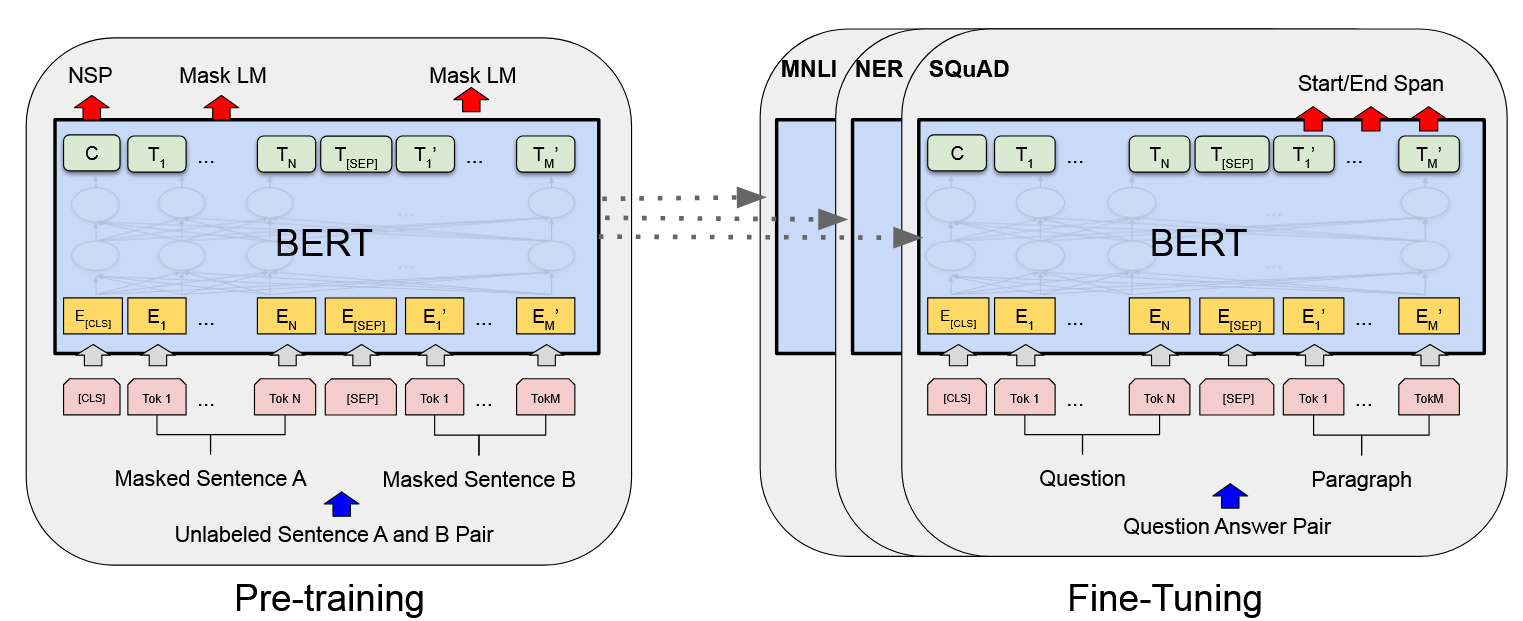
–í –ø–∞–π–ø–ª–∞–π–Ω–µ –ø—Ä–∏–º–µ–Ω—è–µ—Ç—Å—è –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω–∞—è –º–æ–¥–µ–ª—å BERT, self-supervised –∑–∞–¥–∞—á–∞ –Ω–∞ –ø—Ä–µ—Ç—Ä–µ–Ω–∏—Ä–æ–≤–∫–µ —Å–æ—Å—Ç–æ–∏—Ç –∏–∑ 2 —á–∞—Å—Ç–µ–π - $MLM^1$ –∏ $NSP^2$:


1. 15% –ø—Ä–æ—Ü–µ–Ω—Ç–æ–≤ —Ç–æ–∫–µ–Ω–æ–≤ –º–∞—Å–∫–∏—Ä—É—é—Ç—Å—è, —Ç–æ –µ—Å—Ç—å –∑–∞–º–µ–Ω—è—é—Ç—Å—è –Ω–∞ [MASK] 
2. –ë–∏–Ω–∞—Ä–Ω—ã–π –æ–±–¥–∂–µ–∫—Ç–∏–≤-–∏–Ω–¥–∏–∫—Ç–æ—Ä, —è–≤–ª—è—é—Ç—Å—è –¥–ª—è –∑–∞–∫–æ–ª–ª–µ–π—á–µ–Ω—ã—Ö –≤ 1 —Å—ç–º–ø–ª –ø—Ä–µ–ª–æ–∂–µ–Ω–∏—è —Ä–µ–∞–ª—å–Ω–æ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ –≤—Å—Ç—Ä–µ—á–∞—é—â–∏–º–∏—Å—è –≤ —Ç–µ–∫—Å—Ç–µ.

NER-–∑–∞–¥–∞—á–∞ —Å–≤–æ–¥–∏—Ç—Å—è –∫ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏ –∫–∞–∂–¥–æ–≥–æ —Ç–æ–∫–µ–Ω–∞, —á—Ç–æ –æ–∑–Ω–∞—á–∞–µ—Ç, —á—Ç–æ –±–æ–ª—å—à–µ –ø–æ–¥—Ö–æ–¥–∏—Ç –¥–∏—Å–∫—Ä–∏–º–∏–Ω–∞—Ç–∏–≤–Ω–∞—è –º–æ–¥–µ–ª—å, –µ–π –∏ —è–≤–ª—è–µ—Ç—Å—è BERT; —Å–ø–µ—Ü–∏—Ñ–∏–∫–∞ NER –∑–∞–¥–∞—á–∏ —Ç–∞–∫–∂–µ —Ç—Ä–µ–±—É–µ—Ç cased-—Ç–æ–∫–µ–Ω–∏–∑–∞—Ü–∏–∏, —Ç–∞–∫ –∫–∞–∫ –ø–æ—Ç–µ–Ω—Ü–∏–∞–ª—å–Ω–æ –ø–æ–º–æ–∂–µ—Ç –≤ –Ω–µ–∫–æ—Ç–æ—Ä—ã—Ö —Å–ª—É—á–∞—è—Ö –æ–ø—Ä–µ–¥–µ–ª–∏—Ç—å —Å–æ–±—Å—Ç–≤–µ–Ω–Ω—ã–µ –∏–º–µ–Ω–∞.

EDA –¥–∞—Ç–∞—Å–µ—Ç–∞ –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç –æ—Ü–µ–Ω–∫—É –¥–ª–∏–Ω—ã –≤ —Å–ª–æ–≤–∞—Ö, BPE, –∫–∞–∫ subword –º–µ—Ç–æ–¥, —É–≤–µ–ª–∏—á–∏–≤–∞–µ—Ç –¥–ª–∏–Ω—É –ø–æ—Å–ª–µ —Ç–æ–∫–µ–Ω–∏–∑–∞—Ü–∏–∏; —Ä–∞—Å–ø—Ä–æ—Å—Ç—Ä–∞–Ω–µ–Ω–Ω–æ–π –æ—Ü–µ–Ω–∫–æ–π —è–≤–ª—è–µ—Ç—Å—è $|text|_{words}\approx 0.75 \times |text|_{BPE-tokens}$ 

In [10]:
MODEL_NAME = "bert-base-cased"
MAX_LENGTH = 256
BATCH_SIZE = 32
NUM_EPOCHS = 15
LEARNING_RATE = 2e-5

In [11]:
ds_full = dataset = DatasetDict(
    {"train": ds_train, "validation": ds_val, "test": ds_test}
)

In [12]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [13]:
label2id = {label: i for i, label in enumerate(LABEL_NAMES)}
id2label = {i: label for i, label in enumerate(LABEL_NAMES)}

In [14]:
def tokenize_and_align_labels(examples):
    """
    –¢–æ–∫–µ–Ω–∏–∑–∞—Ü–∏—è —Ç–µ–∫—Å—Ç–∞ –∏ –≤—ã—Ä–∞–≤–Ω–∏–≤–∞–Ω–∏–µ –º–µ—Ç–æ–∫ —Å —É—á–µ—Ç–æ–º —Ä–∞–∑–¥–µ–ª–µ–Ω–∏—è –Ω–∞ –ø–æ–¥—Ç–æ–∫–µ–Ω—ã
    """
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding=False,
        is_split_into_words=True,
        max_length=MAX_LENGTH,
        return_tensors=None,  # –ë—É–¥–µ–º –≤–æ–∑–≤—Ä–∞—â–∞—Ç—å —Å–ø–∏—Å–∫–∏, –∞ –Ω–µ —Ç–µ–Ω–∑–æ—Ä—ã
    )

    labels = []
    for i, label in enumerate(examples["tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            # –°–ø–µ—Ü–∏–∞–ª—å–Ω—ã–µ —Ç–æ–∫–µ–Ω—ã –ø–æ–ª—É—á–∞—é—Ç –º–µ—Ç–∫—É -100
            if word_idx is None:
                label_ids.append(-100)
            # –î–ª—è –ø–µ—Ä–≤–æ–≥–æ —Ç–æ–∫–µ–Ω–∞ –∫–∞–∂–¥–æ–≥–æ —Å–ª–æ–≤–∞ –∏—Å–ø–æ–ª—å–∑—É–µ–º —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â—É—é –º–µ—Ç–∫—É
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # –î–ª—è –ø–æ–¥—Ç–æ–∫–µ–Ω–æ–≤ –∏—Å–ø–æ–ª—å–∑—É–µ–º –º–µ—Ç–∫—É -100 –∏–ª–∏ –º–µ—Ç–∫—É —Ç–µ–∫—É—â–µ–≥–æ —Å–ª–æ–≤–∞ (–≤ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ—Ç –∑–∞–¥–∞—á–∏)
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [15]:
tokenized_datasets = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset["train"].column_names,
)

Map:   0%|          | 0/115812 [00:00<?, ? examples/s]

Map:   0%|          | 0/15680 [00:00<?, ? examples/s]

Map:   0%|          | 0/12217 [00:00<?, ? examples/s]

In [16]:
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME, num_labels=len(LABEL_NAMES), id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, padding=True)

In [18]:
metric = evaluate.load("seqeval")

In [21]:
def compute_metrics(p):
    """
    –í—ã—á–∏—Å–ª–µ–Ω–∏–µ –º–µ—Ç—Ä–∏–∫ (precision, recall, f1) –¥–ª—è NER
    """
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # –£–±–∏—Ä–∞–µ–º —Å–ø–µ—Ü–∏–∞–ª—å–Ω—ã–µ —Ç–æ–∫–µ–Ω—ã (–º–µ—Ç–∫–∞ -100)
    true_predictions = [
        [LABEL_NAMES[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [LABEL_NAMES[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [22]:
training_args = TrainingArguments(
    output_dir="./ner-model",
    evaluation_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    push_to_hub=False,
    report_to=None,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True, 
    save_total_limit=1, 
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(


In [23]:
import wandb
import os

os.environ["WANDB_DISABLED"] = "false"
wandb.init(mode="disabled")

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipykernel_36/720657926.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [25]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=27150, training_loss=0.021800901393644496, metrics={'train_runtime': 15055.1655, 'train_samples_per_second': 115.388, 'train_steps_per_second': 1.803, 'total_flos': 6.80211403224432e+16, 'train_loss': 0.021800901393644496, 'epoch': 15.0})

In [26]:
trainer.save_model("./ner-final-model-15-epochs")

In [ ]:
# predictions = trainer.predict(tokenized_datasets["validation"])

In [ ]:
# print(predictions.metrics)

In [ ]:
# for batch in trainer.get_eval_dataloader():
#     break

# # –û—Ç–ø—Ä–∞–≤–ª—è–µ–º –±–∞—Ç—á –≤ –º–æ–¥–µ–ª—å (–ø—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ—Ç—Å—è, —á—Ç–æ –º–æ–¥–µ–ª—å —É–∂–µ –Ω–∞—Ç—Ä–µ–Ω–∏—Ä–æ–≤–∞–Ω–∞)
# model.eval()
# with torch.no_grad():
#     outputs = model(batch["input_ids"].to(trainer.args.device))

# # –ü–æ–ª—É—á–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–µ –º–µ—Ç–∫–∏ (–∏–Ω–¥–µ–∫—Å—ã –∫–ª–∞—Å—Å–æ–≤ —Å –Ω–∞–∏–±–æ–ª—å—à–µ–π –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å—é)
# predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
# input_ids = batch["input_ids"].cpu().numpy()
# labels = batch["labels"].cpu().numpy()

# # –í—ã–≤–æ–¥–∏–º –ø–µ—Ä–≤—ã–µ –Ω–µ—Å–∫–æ–ª—å–∫–æ –ø—Ä–∏–º–µ—Ä–æ–≤ –∏–∑ –±–∞—Ç—á–∞
# for i in range(3):
#     print(f"\n--- –ü—Ä–∏–º–µ—Ä {i+1} ---")
#     # –î–µ–∫–æ–¥–∏—Ä—É–µ–º —Ç–æ–∫–µ–Ω—ã –æ–±—Ä–∞—Ç–Ω–æ –≤ —Å–ª–æ–≤–∞, –ø—Ä–æ–ø—É—Å–∫–∞—è —Å–ø–µ—Ü–∏–∞–ª—å–Ω—ã–µ —Ç–æ–∫–µ–Ω—ã
#     tokens = tokenizer.convert_ids_to_tokens(input_ids[i], skip_special_tokens=False)
#     pred_tags = [LABEL_NAMES[p] if p != -100 else "O" for p in predictions[i]]
#     true_tags = [LABEL_NAMES[l] if l != -100 else "O" for l in labels[i]]

#     # –ö—Ä–∞—Å–∏–≤–æ –≤—ã–≤–æ–¥–∏–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç
#     for token, pred, true in zip(tokens, pred_tags, true_tags):
#         print(f"{token:15} | {true:15} | {pred:15}")

In [27]:
predictions = trainer.predict(tokenized_datasets["test"])

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [ ]:
def convert_predictions_simple(original_dataset, predictions, label_names):
    """
    –£–ø—Ä–æ—â–µ–Ω–Ω–∞—è –≤–µ—Ä—Å–∏—è - —Ä–∞–±–æ—Ç–∞–µ—Ç –Ω–∞–ø—Ä—è–º—É—é —Å –∏—Å—Ö–æ–¥–Ω—ã–º–∏ —Å–ª–æ–≤–∞–º–∏
    """
    word_level_predictions = []
    word_level_true_labels = []

    predicted_labels = np.argmax(predictions.predictions, axis=2)

    for i in range(len(original_dataset)):
        original_tokens = original_dataset[i]["tokens"]
        original_tags = original_dataset[i]["tags"]

        # –î–ª—è –∫–∞–∂–¥–æ–≥–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è –∑–∞–Ω–æ–≤–æ —Ç–æ–∫–µ–Ω–∏–∑–∏—Ä—É–µ–º –∏ –Ω–∞—Ö–æ–¥–∏–º —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤–∏—è
        encoded = tokenizer(
            original_tokens,
            is_split_into_words=True,
            truncation=True,
            max_length=MAX_LENGTH,
            return_offsets_mapping=False,
        )

        word_predictions = []
        word_true_labels = [label_names[tag] for tag in original_tags]

        # –ü—Ä–æ—Ö–æ–¥–∏–º –ø–æ –∫–∞–∂–¥–æ–º—É —Å–ª–æ–≤—É –∏ –Ω–∞—Ö–æ–¥–∏–º –µ–≥–æ –ø–µ—Ä–≤—ã–π —Ç–æ–∫–µ–Ω
        word_ids = []
        for word_idx in range(len(original_tokens)):
            # –ù–∞—Ö–æ–¥–∏–º –ø–æ–∑–∏—Ü–∏—é –ø–µ—Ä–≤–æ–≥–æ —Ç–æ–∫–µ–Ω–∞ –¥–ª—è —ç—Ç–æ–≥–æ —Å–ª–æ–≤–∞
            found = False
            for token_idx, token_word_idx in enumerate(encoded.word_ids()):
                if token_word_idx == word_idx:
                    # –≠—Ç–æ –ø–µ—Ä–≤—ã–π —Ç–æ–∫–µ–Ω —Å–ª–æ–≤–∞ - –±–µ—Ä–µ–º –µ–≥–æ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ
                    if token_idx < len(predicted_labels[i]):
                        word_predictions.append(
                            label_names[predicted_labels[i][token_idx]]
                        )
                    else:
                        word_predictions.append("O")
                    found = True
                    break
            if not found:
                word_predictions.append("O")  # –°–ª–æ–≤–æ –±—ã–ª–æ –æ–±—Ä–µ–∑–∞–Ω–æ

        word_level_predictions.append(word_predictions)
        word_level_true_labels.append(word_true_labels)

    return word_level_predictions, word_level_true_labels

all_word_predictions, all_word_true_labels = convert_predictions_simple(
    ds_test, predictions, LABEL_NAMES
)

In [29]:
results = metric.compute(
    predictions=all_word_predictions, references=all_word_true_labels
)


print("Overall Metrics:")
print(f"Precision: {results['overall_precision']:.4f}")
print(f"Recall: {results['overall_recall']:.4f}")
print(f"F1-Score: {results['overall_f1']:.4f}")
print(f"Accuracy: {results['overall_accuracy']:.4f}")

print("\nDetailed Metrics per class:")
for key in results:
    if key not in [
        "overall_precision",
        "overall_recall",
        "overall_f1",
        "overall_accuracy",
    ]:
        print(f"\n{key}:")
        print(f"  Precision: {results[key]['precision']:.4f}")
        print(f"  Recall: {results[key]['recall']:.4f}")
        print(f"  F1-Score: {results[key]['f1']:.4f}")

Overall Metrics:
Precision: 0.8388
Recall: 0.8689
F1-Score: 0.8536
Accuracy: 0.9792

Detailed Metrics per class:

CARDINAL:
  Precision: 0.7909
  Recall: 0.7980
  F1-Score: 0.7945

DATE:
  Precision: 0.7985
  Recall: 0.8607
  F1-Score: 0.8284

EVENT:
  Precision: 0.5882
  Recall: 0.7059
  F1-Score: 0.6417

FAC:
  Precision: 0.6879
  Recall: 0.6510
  F1-Score: 0.6690

GPE:
  Precision: 0.9216
  Recall: 0.9097
  F1-Score: 0.9156

LANGUAGE:
  Precision: 0.8333
  Recall: 0.6818
  F1-Score: 0.7500

LAW:
  Precision: 0.5882
  Recall: 0.6818
  F1-Score: 0.6316

LOC:
  Precision: 0.6375
  Recall: 0.7442
  F1-Score: 0.6867

MONEY:
  Precision: 0.8587
  Recall: 0.9070
  F1-Score: 0.8822

NORP:
  Precision: 0.8712
  Recall: 0.9222
  F1-Score: 0.8960

ORDINAL:
  Precision: 0.7104
  Recall: 0.7585
  F1-Score: 0.7336

ORG:
  Precision: 0.8543
  Recall: 0.8991
  F1-Score: 0.8761

PERCENT:
  Precision: 0.8521
  Recall: 0.8897
  F1-Score: 0.8705

PERSON:
  Precision: 0.9033
  Recall: 0.9105
  F1-Score:

In [30]:
from collections import defaultdict


def print_examples_by_class(
    all_word_predictions,
    all_word_true_labels,
    original_dataset,
    label_names,
    num_examples=2,
):
    """
    –í—ã–≤–æ–¥–∏—Ç –ø—Ä–∏–º–µ—Ä—ã –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∫–ª–∞—Å—Å–∞, –≥–¥–µ –≤ GT –µ—Å—Ç—å —ç—Ç–æ—Ç –∫–ª–∞—Å—Å
    """

    # –°–æ–±–∏—Ä–∞–µ–º –ø—Ä–∏–º–µ—Ä—ã –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∫–ª–∞—Å—Å–∞
    class_examples = defaultdict(list)

    for i in range(len(all_word_predictions)):
        true_labels = all_word_true_labels[i]
        pred_labels = all_word_predictions[i]
        tokens = original_dataset[i]["tokens"]

        # –ù–∞—Ö–æ–¥–∏–º —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ –∫–ª–∞—Å—Å—ã –≤ —ç—Ç–æ–º –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–∏ (–∏—Å–∫–ª—é—á–∞—è 'O')
        present_classes = set()
        for label in true_labels:
            if label != "O":
                present_classes.add(label)

        # –î–ª—è –∫–∞–∂–¥–æ–≥–æ –ø—Ä–∏—Å—É—Ç—Å—Ç–≤—É—é—â–µ–≥–æ –∫–ª–∞—Å—Å–∞ —Å–æ—Ö—Ä–∞–Ω—è–µ–º –ø—Ä–∏–º–µ—Ä
        for cls in present_classes:
            if len(class_examples[cls]) < num_examples:
                class_examples[cls].append(
                    {"tokens": tokens, "true": true_labels, "pred": pred_labels}
                )

    # –í—ã–≤–æ–¥–∏–º –ø—Ä–∏–º–µ—Ä—ã –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∫–ª–∞—Å—Å–∞
    for cls in sorted(class_examples.keys()):
        print(f"\n{'='*80}")
        print(f"–ö–õ–ê–°–°: {cls}")
        print(f"{'='*80}")

        for example_idx, example in enumerate(class_examples[cls]):
            print(f"\n–ü—Ä–∏–º–µ—Ä {example_idx + 1}:")
            print("-" * 40)

            # –í—ã–≤–æ–¥–∏–º –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ —Å —Ü–≤–µ—Ç–æ–≤–æ–π —Ä–∞–∑–º–µ—Ç–∫–æ–π
            for token, true_label, pred_label in zip(
                example["tokens"], example["true"], example["pred"]
            ):
                true_color = "‚úì" if true_label == cls else " "
                pred_color = "‚úì" if pred_label == cls else " "
                match_indicator = " ‚úÖ" if true_label == pred_label else " ‚ùå"

                print(
                    f"{true_color} {pred_color} {token:15} | GT: {true_label:15} | PRED: {pred_label:15}{match_indicator}"
                )

In [31]:
print_examples_by_class(all_word_predictions, all_word_true_labels, ds_val, LABEL_NAMES)


–ö–õ–ê–°–°: B-CARDINAL

–ü—Ä–∏–º–µ—Ä 1:
----------------------------------------
    While           | GT: O               | PRED: O               ‚úÖ
    in              | GT: B-DATE          | PRED: B-DATE          ‚úÖ
    the             | GT: I-DATE          | PRED: I-DATE          ‚úÖ
    Dominican       | GT: I-DATE          | PRED: I-DATE          ‚úÖ
    Republic        | GT: I-DATE          | PRED: I-DATE          ‚úÖ
    to              | GT: O               | PRED: O               ‚úÖ
‚úì ‚úì attend          | GT: B-CARDINAL      | PRED: B-CARDINAL      ‚úÖ
    the             | GT: O               | PRED: O               ‚úÖ
    inauguration    | GT: O               | PRED: O               ‚úÖ
    of              | GT: O               | PRED: O               ‚úÖ
    President       | GT: O               | PRED: O               ‚úÖ
    Hipolito        | GT: O               | PRED: O               ‚úÖ
    Mejia           | GT: O               | PRED: O               ‚úÖ
    